In [11]:
from db import get_db_connection

conn = get_db_connection()
cursor = conn.cursor()

cursor.execute('''
    SELECT track.id, track.name, artist.id, artist.name, album.id, album.name, album.release_date, album.release_date_precision, aa.analysis FROM track
        JOIN track_artist_join ON track_artist_join.track_id = track.id
        JOIN artist ON track_artist_join.artist_id = artist.id
        JOIN track_album_join ON track_album_join.track_id = track.id
        JOIN album ON track_album_join.album_id = album.id
        JOIN audio_analysis aa ON aa.track_id = track.id
    WHERE track.name NOT LIKE '%remaster%' AND album.name NOT LIKE '%remaster%'
''')
tracks = cursor.fetchall()

In [12]:
# munge data into something we can plot
from datetime import datetime
import json

data = []

for track in tracks:
    release_date = track[6]
    release_date_precision = track[7]


    if release_date_precision == 'day':
        release_date = datetime.strptime(release_date, '%Y-%m-%d')
    elif release_date_precision == 'month':
        release_date = datetime.strptime(release_date, '%Y-%m')
    elif release_date_precision == 'year':
        release_date = datetime.strptime(release_date, '%Y')

    loudness = json.loads(track[8])['track']['loudness']

    data.append({
        'title': track[1],
        'artist': track[3],
        'release_date': release_date,
        'loudness': loudness
    })

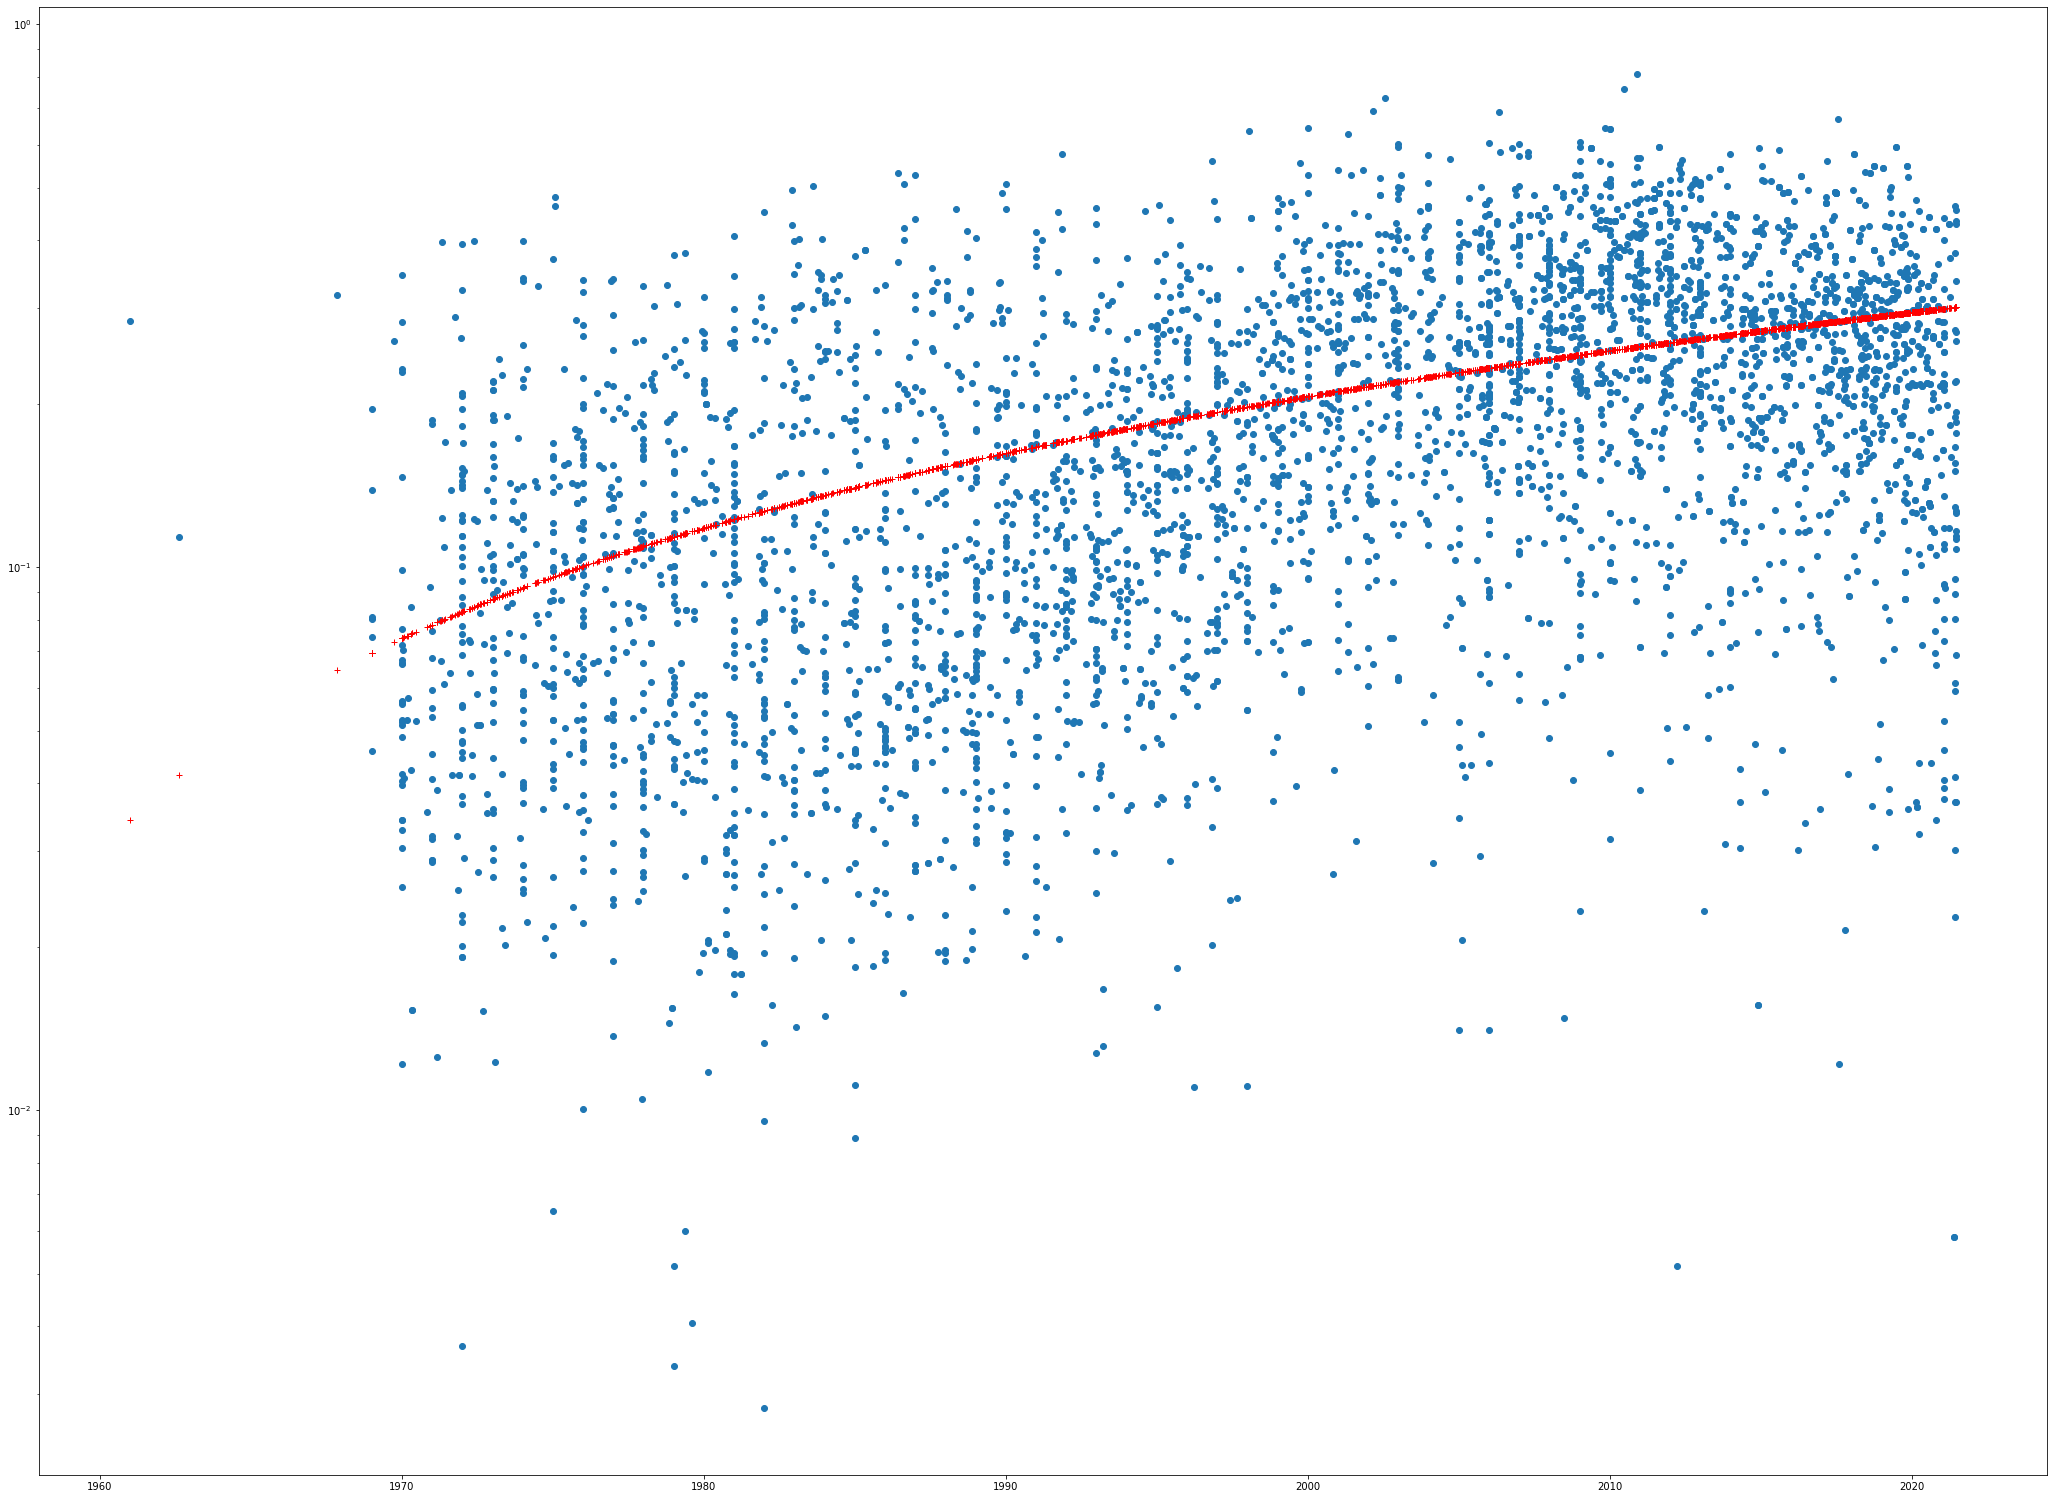

In [13]:
from math import log
import matplotlib.pyplot as plt

def convert_decibel_to_log(val):
    return 10 ** (val / 10)

plt.figure(figsize=(36, 27))
plt.yscale('log')
x = [track['release_date'] for track in data]
y= [convert_decibel_to_log(track['loudness']) for track in data]
plt.scatter(x, y)

# add a trendline
import numpy as np
import matplotlib.dates as mdates

x_as_num = mdates.date2num(x)

trendline = np.polyfit(x_as_num, y, 1)
p = np.poly1d(trendline)
plt.plot(x, p(x_as_num), 'r+')